# Improving Type 2 Diabetes Risk Prediction with an XGBoost Model

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
def create_features(df):
    df_new = df.copy()
    
    df_new['BMICategory'] = pd.cut(df_new['BMI'], bins=[0, 18.5, 25, 30, 100], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    df_new['GlucoseCategory'] = pd.cut(df_new['Glucose'], bins=[0, 140, 200, 500], labels=['Normal', 'Prediabetes', 'Diabetic'])
    
    df_new['Glucose_x_BMI'] = df_new['Glucose'] * df_new['BMI']
    
    df_new = pd.get_dummies(df_new, columns=['BMICategory', 'GlucoseCategory'], drop_first=True)
    
    return df_new

In [ ]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, header=None, names=column_names)

X_raw = data.drop('Outcome', axis=1)
y = data['Outcome']

X_featured = create_features(X_raw)

print("Original number of features:", len(X_raw.columns))
print("Number of features after engineering:", len(X_featured.columns))
print("\nNew features added:")
print(X_featured.columns)

X_train, X_test, y_train, y_test = train_test_split(X_featured, y, test_size=0.2, random_state=42, stratify=y)

Original number of features: 8
Number of features after engineering: 14

New features added:
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_x_BMI',
       'BMICategory_Normal', 'BMICategory_Overweight', 'BMICategory_Obese',
       'GlucoseCategory_Prediabetes', 'GlucoseCategory_Diabetic'],
      dtype='object')


In [ ]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}\n")

pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=42,
        scale_pos_weight=scale_pos_weight
    ))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4],
    'model__learning_rate': [0.05, 0.1]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=kfold, 
                           scoring='recall',
                           n_jobs=-1, 
                           verbose=1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


Calculated scale_pos_weight: 1.87

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\zehra\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:26:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Using manually selected balanced threshold: 0.38

--- Final Performance with Feature Engineering (Threshold: 0.38) ---
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       100
           1       0.62      0.87      0.72        54

    accuracy                           0.77       154
   macro avg       0.76      0.79      0.76       154
weighted avg       0.81      0.77      0.77       154


Final Confusion Matrix with Feature Engineering:


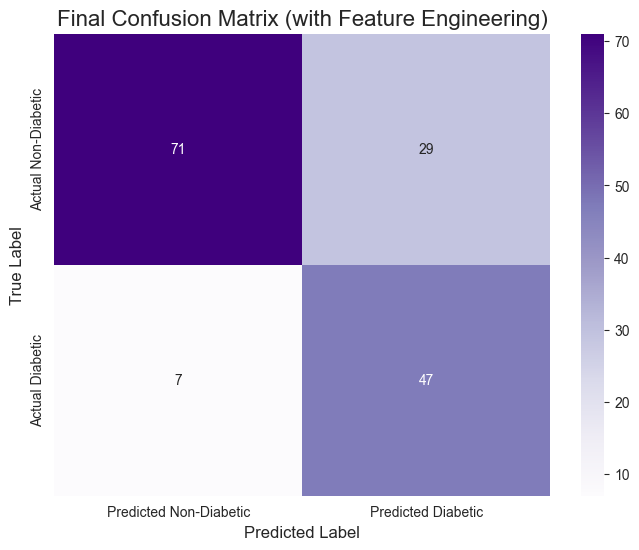

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]

optimal_threshold = 0.38
print(f"Using manually selected balanced threshold: {optimal_threshold}")

y_pred_final = (y_proba >= optimal_threshold).astype('int')

print(f"\n--- Final Performance with Feature Engineering (Threshold: {optimal_threshold}) ---")
print(classification_report(y_test, y_pred_final))

print("\nFinal Confusion Matrix with Feature Engineering:")
final_conf_matrix = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Predicted Non-Diabetic', 'Predicted Diabetic'], 
            yticklabels=['Actual Non-Diabetic', 'Actual Diabetic'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Final Confusion Matrix (with Feature Engineering)', fontsize=16)
plt.show()